### Sistema de Recomendação de Animes

foi realizado no google colab e exportado para o github pois a biblioteca surprise não roda corretamente em versões do python acima da 3.10

In [1]:
!pip install pandas matplotlib seaborn
!pip install numpy==1.26.4
!pip install scikit-surprise==1.1.1

Carregar os dados

In [2]:
import pandas as pd

anime = pd.read_csv("/content/drive/MyDrive/IA DS/DS/Pasta sem nome/anime.csv")
ratings = pd.read_csv("/content/drive/MyDrive/IA DS/DS/Pasta sem nome/rating.csv")

anime.head(), ratings.head()

(   anime_id                              name  \
 0     32281                    Kimi no Na wa.   
 1      5114  Fullmetal Alchemist: Brotherhood   
 2     28977                          Gintama°   
 3      9253                       Steins;Gate   
 4      9969                     Gintama&#039;   
 
                                                genre   type episodes  rating  \
 0               Drama, Romance, School, Supernatural  Movie        1    9.37   
 1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
 2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
 3                                   Sci-Fi, Thriller     TV       24    9.17   
 4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   
 
    members  
 0   200630  
 1   793665  
 2   114262  
 3   673572  
 4   151266  ,
    user_id  anime_id  rating
 0        1        20      -1
 1        1        24      -1
 2        1        79      -1
 3   

Pré-processamento

In [3]:
ratings = ratings[ratings['rating'] != -1]

print("Tamanho após remover avaliações -1:", len(ratings))

anime.info()
ratings.info()

Tamanho após remover avaliações -1: 6337241
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 6337241 entries, 47 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 193.4 MB


Merge

In [4]:
merged = ratings.merge(anime, on="anime_id")
merged.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315


Análise Exploratória dos Dados

Distribuição das avaliações

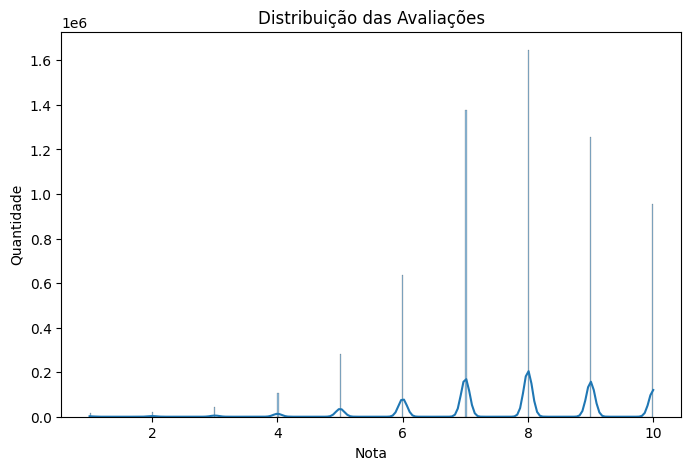

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], kde=True)
plt.title("Distribuição das Avaliações")
plt.xlabel("Nota")
plt.ylabel("Quantidade")
plt.show()

Top 10 animes mais populares (por número de avaliações)

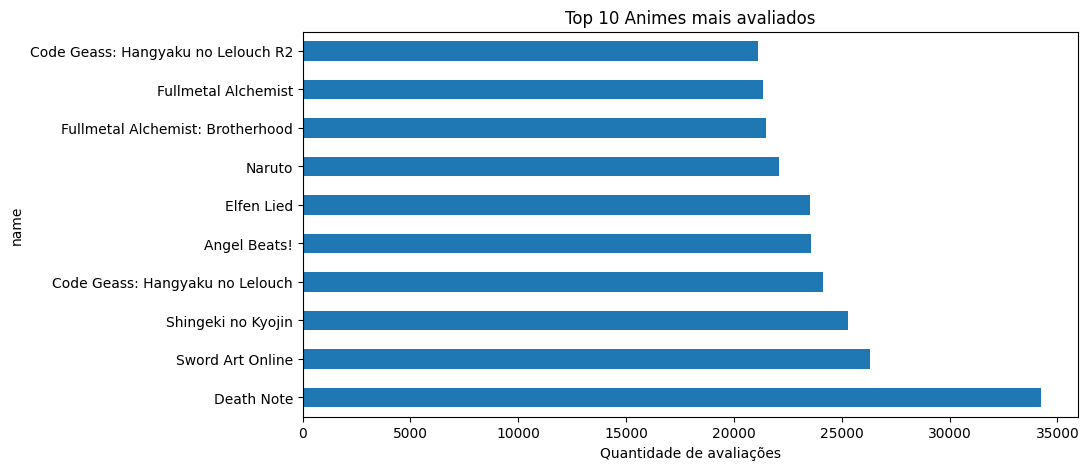

In [6]:
popular = merged['name'].value_counts().head(10)

plt.figure(figsize=(10,5))
popular.plot(kind='barh')
plt.title("Top 10 Animes mais avaliados")
plt.xlabel("Quantidade de avaliações")
plt.show()

Sistema de Recomendação

Usaremos a biblioteca Surprise, com o algoritmo SVD

Preparar os dados

In [7]:
from surprise import Dataset, Reader

reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(ratings[['user_id','anime_id','rating']], reader)

Treinamento + Validação

In [8]:
from surprise import SVD
from surprise.model_selection import cross_validate

model = SVD()

results = cross_validate(model, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1330  1.1341  1.1336  1.1321  1.1331  1.1332  0.0007  
MAE (testset)     0.8453  0.8451  0.8445  0.8443  0.8446  0.8447  0.0004  
Fit time          410.61  416.23  412.66  422.15  413.63  415.06  3.98    
Test time         35.11   36.48   28.53   30.06   35.40   33.12   3.19    


Resultados das métricas

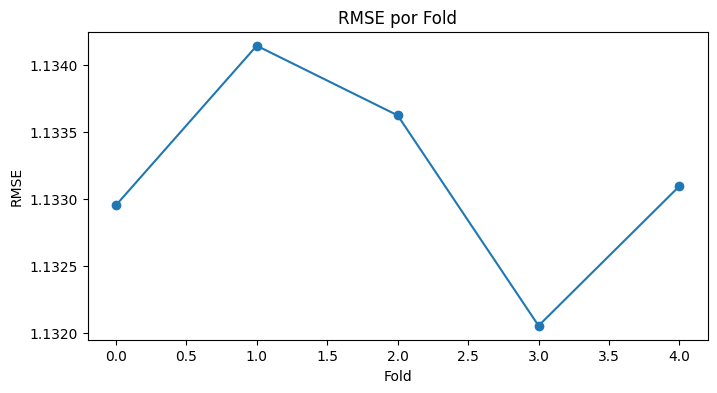

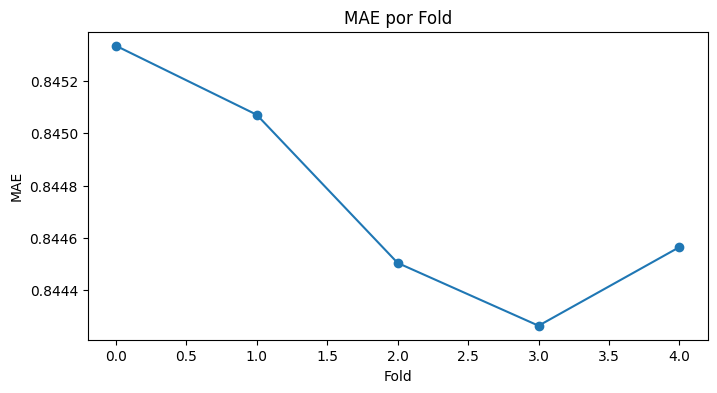

RMSE médio: 1.1331745380269318
MAE médio: 0.8447476956865506


In [9]:
import numpy as np

rmse = results['test_rmse']
mae = results['test_mae']

plt.figure(figsize=(8,4))
plt.plot(rmse, marker='o')
plt.title("RMSE por Fold")
plt.ylabel("RMSE")
plt.xlabel("Fold")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(mae, marker='o')
plt.title("MAE por Fold")
plt.ylabel("MAE")
plt.xlabel("Fold")
plt.show()

print("RMSE médio:", np.mean(rmse))
print("MAE médio:", np.mean(mae))


Modelo final e recomendações

In [10]:
trainset = data.build_full_trainset()
model.fit(trainset)

Função para recomendar animes baseado no usuário

In [11]:
def recomendar_para_usuario(user_id, n=10):
    # pegar todos os animes já avaliados pelo usuário
    avaliados = ratings[ratings['user_id'] == user_id]['anime_id'].unique()

    # lista de todos os animes
    todos_animes = anime['anime_id'].unique()

    # animes não avaliados
    nao_avaliados = [aid for aid in todos_animes if aid not in avaliados]

    # prever nota para cada um
    preds = []
    for aid in nao_avaliados:
        pred = model.predict(user_id, aid)
        preds.append((aid, pred.est))

    # ordenar
    preds.sort(key=lambda x: x[1], reverse=True)

    # pegar top N
    top = preds[:n]

    # transformar em DataFrame legível
    recs = pd.DataFrame(top, columns=['anime_id','estimativa'])
    recs = recs.merge(anime[['anime_id','name','genre','type','rating']], on='anime_id')

    return recs

In [104]:
usuario_exemplo = ratings['user_id'].sample(1).iloc[0]
print("Usuário selecionado:", usuario_exemplo)

recomendacoes = recomendar_para_usuario(usuario_exemplo, n=10)
recomendacoes

Usuário selecionado: 5836


,anime_id,estimativa,name,genre,type,rating
0,6114,9.387109,Rainbow: Nisha Rokubou no Shichinin,"Drama, Historical, Seinen, Thriller",TV,8.64
1,23273,9.356451,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",TV,8.92
2,4181,9.256381,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,9.06
3,32281,9.208300,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.37
4,31240,9.165687,Re:Zero kara Hajimeru Isekai Seikatsu,"Drama, Fantasy, Psychological, Thriller",TV,8.64
5,11827,9.119066,Kuroinu: Kedakaki Seijo wa Hakudaku ni Somaru,"Action, Fantasy, Hentai",OVA,7.49
6,31043,9.040677,Boku dake ga Inai Machi,"Mystery, Psychological, Seinen, Supernatural",TV,8.65
7,28977,9.036805,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.25
8,10161,9.027600,No.6,"Action, Sci-Fi",TV,7.76
9,6505,9.021533,There She Is!!,"Comedy, Romance",ONA,8.11


Visualização das recomendações

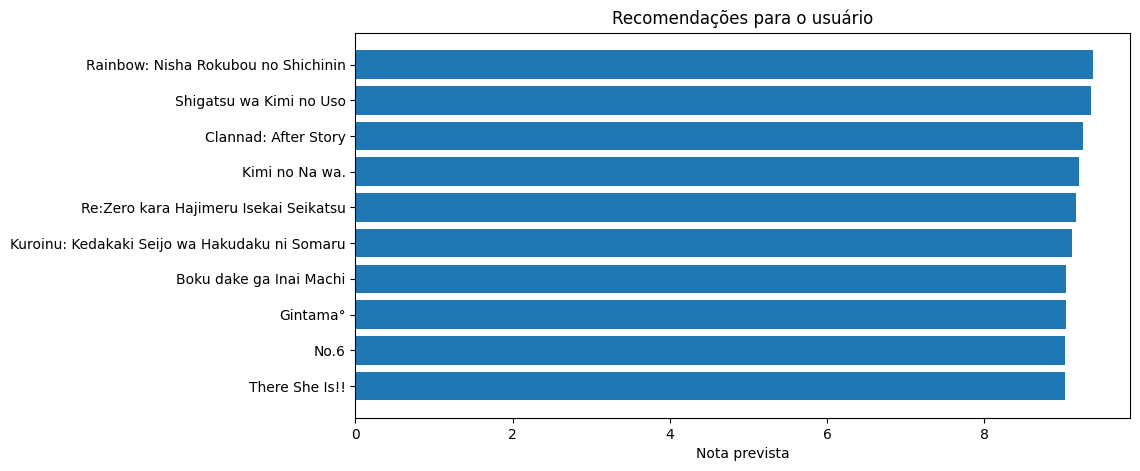

In [105]:
plt.figure(figsize=(10,5))
plt.barh(recomendacoes['name'], recomendacoes['estimativa'])
plt.title("Recomendações para o usuário")
plt.xlabel("Nota prevista")
plt.gca().invert_yaxis()
plt.show()